In [82]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (13, 6)
plt.style.use('ggplot')

# NILMTK: Non-Intrusive Load Monitoring ToolKit 

Se trata de una herramienta *open source* para *investigadores* con la que poder evaluar la precisión de algoritmos de desagregación mediante el uso de métricas. Proporciona además una serie de algoritmos previamente implementados en la plataforma, los cuales se pueden usar como *benchmark*. Además, permite una rápida y fácil evaluación de distintos datasets. 

Pasamos ahora a ver las características más importantes de NILMTK 

## Cargando un dataset y convirtiéndolo al estándar h5

Como ejemplo, usaremos el dataset **REDD**

Primero convertimos al estándar h5. 

In [ ]:
from nilmtk.dataset_converters import convert_redd
convert_redd('../nilmtk/data/REDD/low_freq/', 'data/redd.h5')

Loading house 1... 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
Loading house 2... 1 2 3 4 5 6 7 8 9 10 11 
Loading house 3... 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 

Posteriormente, abrimos el dataset

In [2]:
from nilmtk import DataSet
redd = DataSet('data/redd.h5')

En realidad, todavía no hemos cargado nada en memoria. Simplemente hemos *linkado* los datos a la variable *redd*. No sólo obtenemos un único archivo con todos los datos comprimidos, sino que también obtenemos los metadatos. 

In [4]:
from nilmtk.utils import print_dict
print_dict(redd.metadata)

Los datos se organizan en *buildings* y, dentro de estos, en *elec* (de clase MeterGroup)

In [7]:
print_dict(redd.buildings)
print redd.buildings[1].elec

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='REDD', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='REDD', site_meter, appliances=[])
  ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
  ElecMeter(instance=7, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])
  ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])
  ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
  ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=12, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=1)])
  ElecMeter(instance=13, building=1, dataset='REDD', appliances=[Appliance(type='electric 

Por ejemplo, vamos a seleccionar el frigorífico del edificio 1:

In [14]:
fridge=redd.buildings[1].elec['fridge']

Podemos obtar por volcar todos los datos sobre el frigorífico: 

In [34]:
df=fridge.load().next()

In [38]:
df.head()

physical_quantity,power
type,active
2011-04-18 09:22:13-04:00,5
2011-04-18 09:22:16-04:00,5
2011-04-18 09:22:20-04:00,5
2011-04-18 09:22:23-04:00,5
2011-04-18 09:22:26-04:00,5


O cargar un generador que nos dará los valores en **chunks**. Más eficiente. 

In [39]:
df=fridge.power_series().next()

In [40]:
df.head() # Ojo! Ahora esto es tipo pd.Series. No un dataframe

2011-04-18 09:22:13-04:00    5
2011-04-18 09:22:16-04:00    5
2011-04-18 09:22:20-04:00    5
2011-04-18 09:22:23-04:00    5
2011-04-18 09:22:26-04:00    5
Name: (power, active), dtype: float32

## MeterGroup 

Se trata de la clase clave en nilmtk. Es una lista de *meters*. Estos se pueden agrupar en base a distintos criterios: por edificio, por clase de electrodoméstico, por unidades físicas, etc. En EEUU (el dataset REDD proviene de allí) donde existen ciertos electrodomésticos trifásicos, los MeterGroup se anidan para dar cuenta de esto

In [48]:
elec=redd.buildings[1].elec
elec.nested_metergroups()

[MeterGroup(meters=
   ElecMeter(instance=3, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
   ElecMeter(instance=4, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
 ), MeterGroup(meters=
   ElecMeter(instance=10, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
   ElecMeter(instance=20, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
 )]

Los MeterGroup con nombre *site_meter* se tratan del consumo agregado

In [49]:
elec.mains()

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='REDD', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='REDD', site_meter, appliances=[])
)

## Algunas estadísticas  

La energia total dada en *aparente*: 

In [73]:
elec.mains().total_energy()

Calculating total_energy for ElecMeterID(instance=2, building=1, dataset='REDD') ...   

apparent    167.766283
dtype: float64

y por dispositivo: 

In [91]:
energy_per_meter=elec.submeters().energy_per_meter()
energy_per_meter

15/16 MeterGroup(meters=
  ElecMeter(instance=3, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
  ElecMeter(instance=4, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
16/16 MeterGroup(meters=
  ElecMeter(instance=10, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=20, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
Calculating total_energy for ElecMeterID(instance=20, building=1, dataset='REDD') ...   

,"(5, 1, REDD)","(6, 1, REDD)","(7, 1, REDD)","(8, 1, REDD)","(9, 1, REDD)","(11, 1, REDD)","(12, 1, REDD)","(13, 1, REDD)","(14, 1, REDD)","(15, 1, REDD)","(16, 1, REDD)","(17, 1, REDD)","(18, 1, REDD)","(19, 1, REDD)","(((3, 1, REDD), (4, 1, REDD)),)","(((10, 1, REDD), (20, 1, REDD)),)"
active,44.750925,19.920875,16.786282,22.939649,30.734511,16.890262,5.221226,0.096302,0.411592,4.507334,2.256583,18.288595,11.811224,0.000085,8.81796,32.614809
apparent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Dibujando 

La función plot se puede aplicar directamente a los MeterGroup. Tanto para un único dispositivo: 

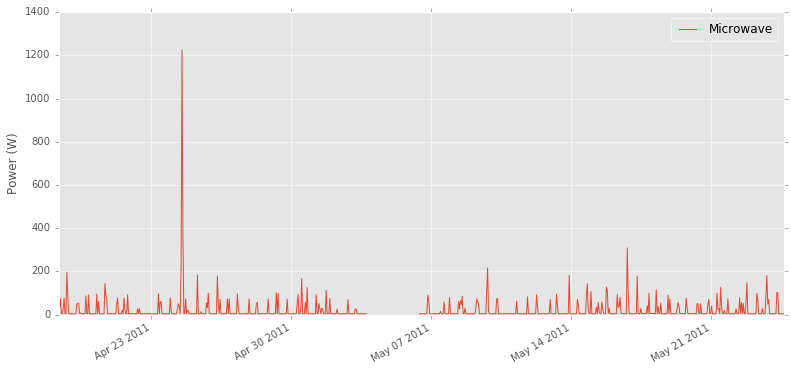

In [83]:
elec['microwave'].plot()

Como para todos: 

Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


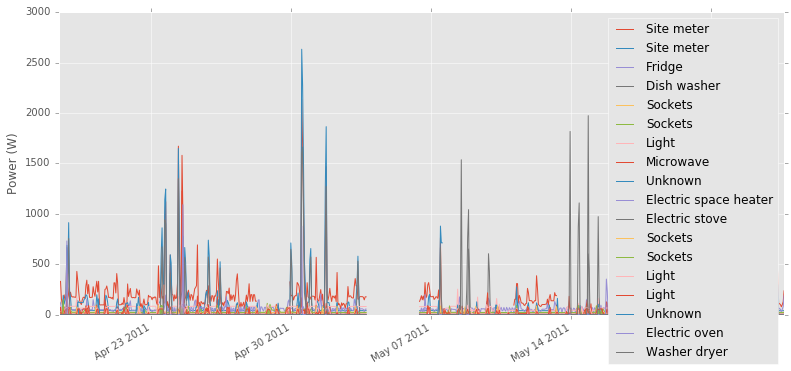

In [117]:
elec.plot()

## Ventanado 

Usamos Timeframe: 

In [144]:
fridge.get_timeframe()

TimeFrame(start='2011-04-18 09:22:13-04:00', end='2011-05-24 15:56:34-04:00', empty=False)

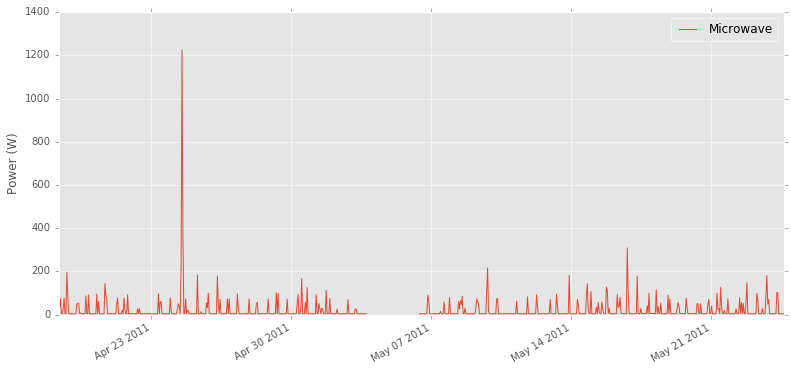

In [143]:
fridge.plot()

In [145]:
from nilmtk import TimeFrame
fridge.store.window = TimeFrame("2011-04-23  20:00:00-04:00", "2011-04-30  20:00:00-04:00")
fridge.get_timeframe()

TimeFrame(start='2011-04-23 20:00:00-04:00', end='2011-04-30 20:00:00-04:00', empty=False)

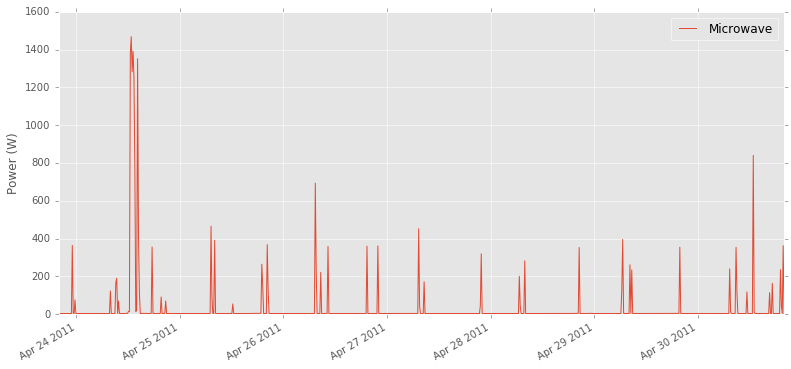

In [146]:
fridge.plot()

Para eliminar el ventanado: 

In [147]:
fridge.store.window.clear()
fridge.get_timeframe()

TimeFrame(start='2011-04-18 09:22:13-04:00', end='2011-05-24 15:56:34-04:00', empty=False)

## Para aprender más de NILMTK: 

https://github.com/nilmtk/nilmtk/tree/master/docs/manual